In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import ResNet50, DenseNet121
import tensorflow as tf
import sklearn

In [2]:
csv_file_path = '../DL_for_Hin_Chest_X_Ray/Data_Entry_2017_filtered_2.csv'
# csv_file_path = '../DL_for_Hin_Chest_X_Ray/HIN_archive/Data_Entry_2017.csv'
df = pd.read_csv(csv_file_path)

IMAGE_DIR = "../DL_for_Hin_Chest_X_Ray/HIN_archive/images/"
ALL_LABELS = sorted(df["Finding Labels"].str.split("|").explode().unique())
ALL_LABELS_WITHOUT_NO = [l for l in ALL_LABELS if l != "No Finding"]
NUMBER_CLASSES = len(ALL_LABELS)

def preprocess_image(file_path, image_size):
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None
    image = cv2.resize(image, (image_size, image_size))
    return image

def prepare_data(df, image_size, image_dir=IMAGE_DIR):
    images = []
    labels = []
    
    for _, row in tqdm(df.iterrows(), total=len(df)):
        image_path = os.path.join(image_dir, row["Image Index"])
        image = preprocess_image(image_path, image_size)
        
        if image is not None:
            images.append(image)

            current_label = np.zeros(NUMBER_CLASSES, dtype=int)
        
            if row["Finding Labels"] != "No Finding":
                indices = [i for i, label in enumerate(ALL_LABELS_WITHOUT_NO) if label in sorted(row["Finding Labels"].split("|"))]
                for idx in indices:
                    if 0 <= idx < NUMBER_CLASSES:
                        current_label[idx] = 1
            else:
                current_label[NUMBER_CLASSES - 1] = 1
            labels.append(current_label)
    
    images = np.array(images).reshape(-1, image_size, image_size)
    images = np.repeat(images[..., np.newaxis], 3, axis=-1) #rgb
    
    labels = np.array(labels)
    
    return images, labels

In [3]:
def create_resnet_model(image_size):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None)
    base_model.trainable = False
    
    model = Sequential()
    model.add(base_model)
    model.add(Conv2D(2048, (1, 1), activation='relu')) # Transition Layer
    model.add(GlobalAveragePooling2D())   
    model.add(Dense(NUMBER_CLASSES, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[AUC(multi_label=True)])
    return model

In [4]:
def normalize_image(img, label):
    img = tf.cast(img, np.float32) / 255.0
    return img, label

def create_train_dataset(images_train, labels_train, batch_size=16):
    train_dataset = tf.data.Dataset.from_tensor_slices((images_train, labels_train))
    train_dataset = train_dataset.map(normalize_image)
    train_dataset = train_dataset.shuffle(buffer_size=100)
    train_dataset = train_dataset.batch(batch_size, drop_remainder=True)
    train_dataset = train_dataset.repeat()
    return train_dataset

def create_val_dataset(images_val, labels_val, batch_size=16):
    val_dataset = tf.data.Dataset.from_tensor_slices((images_val, labels_val))
    val_dataset = val_dataset.map(normalize_image)
    val_dataset = val_dataset.batch(batch_size, drop_remainder=False)
    return val_dataset

In [5]:
def evaluate_model_2(model, images_test, labels_test, batch_size=16, num_steps=10):
    
    total_samples = len(images_test) 
    step_size = total_samples // num_steps  # Size of each step
    auc_per_class = [0] * NUMBER_CLASSES
    
    for step in range(num_steps):
        start_idx = step * step_size
        end_idx = min((step + 1) * step_size, total_samples)
        
        images_batch = images_test[start_idx:end_idx]
        labels_batch = labels_test[start_idx:end_idx]
        
        images_batch_2 = tf.cast(images_batch, np.float32) / 255.0
        predictions_batch = model.predict(images_batch_2, batch_size=batch_size)
        
        for class_idx in range(NUMBER_CLASSES):
            true_labels_class = labels_batch[:, class_idx]
            
            auc = sklearn.metrics.roc_auc_score(true_labels_class, predictions_batch[:, class_idx])
            print(auc)
            auc_per_class[class_idx] += auc
            
    auc_per_class = [auc / num_steps for auc in auc_per_class]
    
    return auc_per_class, 0, 0

In [ ]:
MAX_NUMBER_IMAGES = 73142

In [6]:
IMAGE_SIZE = 224
BATCH_SIZE = 16
MODEL_PATH = 'modelsAmount/resnet_6/'
MAX_NUMBER_IMAGES = 50000
evaluations = {}

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

images, labels = prepare_data(df[:MAX_NUMBER_IMAGES], IMAGE_SIZE)
images_test, labels_test = prepare_data(df[-(int(MAX_NUMBER_IMAGES / 5)):], IMAGE_SIZE)

with open(f"{MODEL_PATH}images.pkl", "wb") as file:
    pickle.dump(images, file)
with open(f"{MODEL_PATH}labels.pkl", "wb") as file:
    pickle.dump(labels, file)
with open(f"{MODEL_PATH}images_test.pkl", "wb") as file:
    pickle.dump(images_test, file)
with open(f"{MODEL_PATH}labels_test.pkl", "wb") as file:
    pickle.dump(labels_test, file)

100%|██████████| 10000/10000 [02:51<00:00, 58.41it/s]


In [6]:
IMAGE_SIZE = 224
BATCH_SIZE = 16
MODEL_PATH = 'modelsAmount/resnet_6/'
MAX_NUMBER_IMAGES = 50000
evaluations = {}


with open(f"{MODEL_PATH}images.pkl", "rb") as file:
    images = pickle.load(file)
with open(f"{MODEL_PATH}labels.pkl", "rb") as file:
    labels = pickle.load(file)
with open(f"{MODEL_PATH}images_test.pkl", "rb") as file:
    images_test = pickle.load(file)
with open(f"{MODEL_PATH}labels_test.pkl", "rb") as file:
    labels_test = pickle.load(file)

In [ ]:
for amount in [10000]:
    tf.keras.backend.clear_session()

    images_train, images_val, labels_train, labels_val = sklearn.model_selection.train_test_split(images[:amount], labels[:amount], random_state=42, test_size=0.2)
   
    train_dataset = create_train_dataset(images_train, labels_train)
    val_dataset = create_val_dataset(images_val, labels_val)
        
    steps_per_epoch = len(images_train) // BATCH_SIZE
    validation_steps = len(images_val) // BATCH_SIZE
    
    model = create_resnet_model(IMAGE_SIZE)

    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    
    history = model.fit(
        images_train,
        labels_train,
        steps_per_epoch=steps_per_epoch,
        epochs=100,
        validation_data=(images_val, labels_val),
        validation_steps=validation_steps,
        callbacks=[early_stopping]
    )
    
    # model.save(MODEL_PATH + str(amount) + '_final.keras')
    # 
    # evals = evaluate_model_2(model, images_test, labels_test) # fix
    # evaluations[amount] = evals
    # print(evaluations)
    # 
    # with open(f"{MODEL_PATH}history{amount}.pkl", "wb") as file:
    #     pickle.dump(history, file)
    # 
    # with open(f"{MODEL_PATH}evaluations.pkl", "wb") as file:
    #     pickle.dump(evaluations, file)
        
print(evaluations)

2025-03-18 21:45:24.562946: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-03-18 21:45:24.563399: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-03-18 21:45:24.563415: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-03-18 21:45:24.563719: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-18 21:45:24.564102: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2025-03-18 21:45:31.196805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


123/500 ━━━━━━━━━━━━━━━━━━━━ 34s 92ms/step - auc: 0.5843 - loss: 2.8790

In [ ]:
# for amount in [44000]:

for amount in [1000, 5000, 10000, 20000, 30000, 40000, 50000]:
    tf.keras.backend.clear_session()

    images_train, images_val, labels_train, labels_val = sklearn.model_selection.train_test_split(images[:amount], labels[:amount], random_state=42, test_size=0.2)
   
    train_dataset = create_train_dataset(images_train, labels_train)
    val_dataset = create_val_dataset(images_val, labels_val)
        
    steps_per_epoch = len(images_train) // BATCH_SIZE
    validation_steps = len(images_val) // BATCH_SIZE
    
    model = create_resnet_model(IMAGE_SIZE)

    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    
    history = model.fit(
        train_dataset,
        steps_per_epoch=steps_per_epoch,
        epochs=100,
        validation_data=val_dataset,
        validation_steps=validation_steps,
        callbacks=[early_stopping]
    )
    
    model.save(MODEL_PATH + str(amount) + '_final.keras')
    
    evals = evaluate_model_2(model, images_test, labels_test) # fix
    evaluations[amount] = evals
    print(evaluations)
    
    with open(f"{MODEL_PATH}history{amount}.pkl", "wb") as file:
        pickle.dump(history, file)

    with open(f"{MODEL_PATH}evaluations.pkl", "wb") as file:
        pickle.dump(evaluations, file)
        
print(evaluations)

2025-03-18 09:09:56.024289: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-03-18 09:09:56.024406: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-03-18 09:09:56.024425: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-03-18 09:09:56.024823: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-18 09:09:56.025404: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2025-03-18 09:09:58.857670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 176ms/step - auc: 0.4854 - loss: 1.5016 - val_auc: 0.5070 - val_loss: 1.1117
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - auc: 0.4995 - loss: 1.0222 - val_auc: 0.5183 - val_loss: 1.1662
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - auc: 0.4912 - loss: 1.0846 - val_auc: 0.5087 - val_loss: 1.1317
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - auc: 0.5194 - loss: 0.9960 - val_auc: 0.5170 - val_loss: 1.2465
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - auc: 0.4931 - loss: 1.0531 - val_auc: 0.5075 - val_loss: 1.1005
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - auc: 0.5012 - loss: 1.0174 - val_auc: 0.5194 - val_loss: 1.0786
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - auc: 0.5338 - loss: 1.0031 - val_auc: 0.5165 - val_loss: 1.0856
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - auc: 0.5441 - loss: 0.9881 - val_auc: 0.5146 - val_loss: 1.1227
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - auc:

In [ ]:
# resnet 4, evaluations on same images

evaluations4 = {1000: ([0.5841490574218194, 0.5365978195779263, 0.5030567938793096, 0.5394470456713522], 0, 0), 5000: ([0.609868183787244, 0.6156259753266651, 0.589571216753318, 0.6098933366142533], 0, 0), 10000: ([0.6090849664002214, 0.6635231077819824, 0.6161661234664131, 0.6457216188456288], 0, 0), 20000: ([0.6109117641386872, 0.6871840742526674, 0.613840154627441, 0.6522705421909071], 0, 0), 30000: ([0.6116947607803203, 0.7025573175278497, 0.620497867076452, 0.6610828570452411], 0, 0), 40000: ([0.6097009621489003, 0.7119941288318201, 0.6252678315155984, 0.6647433114458209], 0, 0), 50000: ([0.5319275796202232, 0.4854422895418919, 0.5001905339464547, 0.5042448470428692], 0, 0)}

# resnet5, as well
evaluations5 = {1000: ([0.5722433619590344, 0.5601782437628127, 0.5676161280486687, 0.5702700616400442], 0, 0), 5000: ([0.589633439750994, 0.6433645919551633, 0.5925845345795391, 0.6299375163009063], 0, 0), 10000: ([0.597012619746545, 0.6591905965184912, 0.6034838782473867, 0.6348572768028906], 0, 0), 20000: ([0.6100367921465821, 0.6914004009778256, 0.6168105099967441, 0.6531414848733504], 0, 0), 30000: ([0.6127876855747237, 0.7011217799314934, 0.6163565320354832, 0.6592267611112853], 0, 0), 40000: ([0.616378551563905, 0.723599283326448, 0.6237336637805956, 0.6660194084585178], 0, 0)}

#resnet 6, as well
evaluations6 = {1000: ([0.5721266975811832, 0.5560206693659023, 0.5626609994096458, 0.5662762208691129], 0, 0), 5000: ([0.5909622222450608, 0.6424883864674352, 0.5918955752282395, 0.6298333476334197], 0, 0), 10000: ([0.6011053158605603, 0.6627050937092187, 0.6063134662960087, 0.6376975924511928], 0, 0), 20000: ([0.6081676546645143, 0.6892624542718719, 0.6161844289734153, 0.6520885762780548], 0, 0), 30000: ([0.6131543004404307, 0.6931596641396323, 0.6161985138567584, 0.6579388046209267], 0, 0), 40000: ([0.6139206402819699, 0.7128259357516497, 0.6202504800910044, 0.6619719544524753], 0, 0)}


[0.014734719112704032, 0.008207415913300896, 0.004232165339078652, 0.0011509673354837577, 0.002008627195831767, 0.0029579711665477116]
0.00554864434382447


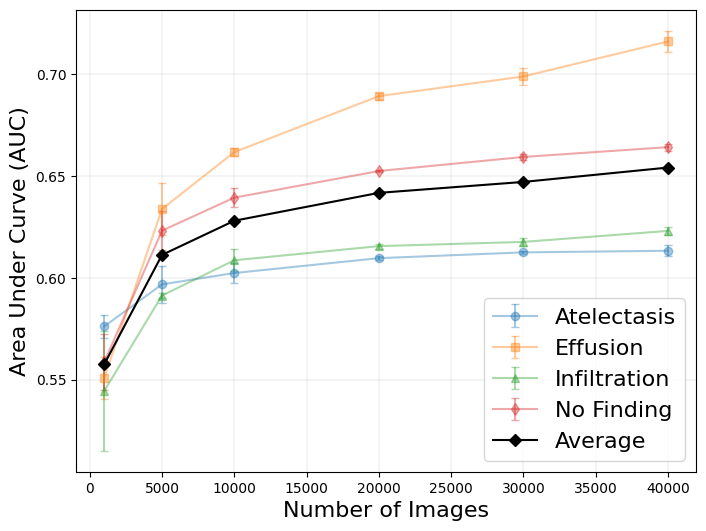

In [9]:
evaluations4 = {1000: ([0.5841490574218194, 0.5365978195779263, 0.5030567938793096, 0.5394470456713522], 0, 0), 5000: ([0.609868183787244, 0.6156259753266651, 0.589571216753318, 0.6098933366142533], 0, 0), 10000: ([0.6090849664002214, 0.6635231077819824, 0.6161661234664131, 0.6457216188456288], 0, 0), 20000: ([0.6109117641386872, 0.6871840742526674, 0.613840154627441, 0.6522705421909071], 0, 0), 30000: ([0.6116947607803203, 0.7025573175278497, 0.620497867076452, 0.6610828570452411], 0, 0), 40000: ([0.6097009621489003, 0.7119941288318201, 0.6252678315155984, 0.6647433114458209], 0, 0), 50000: ([0.5319275796202232, 0.4854422895418919, 0.5001905339464547, 0.5042448470428692], 0, 0)}

# resnet5, as well
evaluations5 = {1000: ([0.5722433619590344, 0.5601782437628127, 0.5676161280486687, 0.5702700616400442], 0, 0), 5000: ([0.589633439750994, 0.6433645919551633, 0.5925845345795391, 0.6299375163009063], 0, 0), 10000: ([0.597012619746545, 0.6591905965184912, 0.6034838782473867, 0.6348572768028906], 0, 0), 20000: ([0.6100367921465821, 0.6914004009778256, 0.6168105099967441, 0.6531414848733504], 0, 0), 30000: ([0.6127876855747237, 0.7011217799314934, 0.6163565320354832, 0.6592267611112853], 0, 0), 40000: ([0.616378551563905, 0.723599283326448, 0.6237336637805956, 0.6660194084585178], 0, 0)}

evaluations6 = {1000: ([0.5721266975811832, 0.5560206693659023, 0.5626609994096458, 0.5662762208691129], 0, 0), 5000: ([0.5909622222450608, 0.6424883864674352, 0.5918955752282395, 0.6298333476334197], 0, 0), 10000: ([0.6011053158605603, 0.6627050937092187, 0.6063134662960087, 0.6376975924511928], 0, 0), 20000: ([0.6081676546645143, 0.6892624542718719, 0.6161844289734153, 0.6520885762780548], 0, 0), 30000: ([0.6131543004404307, 0.6931596641396323, 0.6161985138567584, 0.6579388046209267], 0, 0), 40000: ([0.6139206402819699, 0.7128259357516497, 0.6202504800910044, 0.6619719544524753], 0, 0)}


evaluations = {
    key: [
        evaluations4.get(key, (None, None, None)),
        evaluations5.get(key, (None, None, None)),
        evaluations6.get(key, (None, None, None))
    ]
    for key in sorted(set(evaluations4) | set(evaluations5) | set(evaluations6))
}
evaluations.pop(50000)

###############

plt.figure(figsize=(8, 6))

aucs_at_means = []
aucs_at_stds = []
aucs_ef_means = []
aucs_ef_stds = []
aucs_in_means = []
aucs_in_stds = []
aucs_nf_means = []
aucs_nf_stds = []
aucs_All_means = []
aucs_All_stds = []
baccs_means = []
baccs_stds = []
accs_means = []
accs_stds = []


for evals_per_epoch in evaluations.values():
    aucs_at = []
    aucs_ef = []
    aucs_in = []
    aucs_nf = []
    baccs = []
    accs = []
    
    for eval in evals_per_epoch:
        aucs_at.append(eval[0][0])
        aucs_ef.append(eval[0][1])
        aucs_in.append(eval[0][2])
        aucs_nf.append(eval[0][3])
        baccs.append(eval[1])
        accs.append(eval[2])

    aucs_at_means.append(np.mean(aucs_at))
    aucs_at_stds.append(np.std(aucs_at))
    aucs_ef_means.append(np.mean(aucs_ef))
    aucs_ef_stds.append(np.std(aucs_ef))
    aucs_in_means.append(np.mean(aucs_in))
    aucs_in_stds.append(np.std(aucs_in))
    aucs_nf_means.append(np.mean(aucs_nf))
    aucs_nf_stds.append(np.std(aucs_nf))
    aucs_All_means.append(np.mean(np.concatenate((aucs_at, aucs_ef, aucs_in, aucs_nf))))
    aucs_All_stds.append(np.std(np.concatenate((aucs_at, aucs_ef, aucs_in, aucs_nf))))
    baccs_means.append(np.mean(baccs))
    baccs_stds.append(np.std(baccs))
    accs_means.append(np.mean(accs))
    accs_stds.append(np.std(accs))
    
average_stds_per_epoch = []
for epoch_stds in zip(aucs_at_stds, aucs_ef_stds, aucs_in_stds, aucs_nf_stds):
    average_stds_per_epoch.append(np.mean(epoch_stds))

print(average_stds_per_epoch)
overall_average_std = np.mean(average_stds_per_epoch)
print(overall_average_std)


x_values = evaluations.keys()

font_size = 16

alpha = 0.4

plt.errorbar(x_values, aucs_at_means, yerr=aucs_at_stds, label='Atelectasis', fmt='-o', capsize=3, alpha=alpha)
plt.errorbar(x_values, aucs_ef_means, yerr=aucs_ef_stds, label='Effusion', fmt='-s', capsize=3, alpha=alpha)
plt.errorbar(x_values, aucs_in_means, yerr=aucs_in_stds, label='Infiltration', fmt='-^', capsize=3, alpha=alpha)
plt.errorbar(x_values, aucs_nf_means, yerr=aucs_nf_stds, label='No Finding', fmt='-d', capsize=3, alpha=alpha)
plt.errorbar(x_values, aucs_All_means, label='Average', marker='D', color='black')

# plt.plot(x_values, aucs_at_means, label='Atelectasis')
# plt.plot(x_values, aucs_ef_means, label='Effusion')
# plt.plot(x_values, aucs_in_means, label='Infiltration')
# plt.plot(x_values, aucs_nf_means, label='No Finding')
# plt.plot(x_values, aucs_All_means, color='black', label='Average')

plt.ylabel("Area Under Curve (AUC)", fontsize=font_size)
plt.xlabel("Number of Images", fontsize=font_size)
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.legend(fontsize=font_size, loc="lower right")

# plt.savefig("evalsNew/amountImagesTest_10000samples_5runs.pdf", bbox_inches='tight', pad_inches=0)

plt.show()

In [ ]:
# resnet 2, evaluations performed on same images
evaluations[1000] = [0.5951705342080308, 0.5952834163730929, 0.5491585549328315, 0.5837986844451944]
evaluations[5000] = [0.5891045793542963, 0.6419020893294389, 0.5932313546781207, 0.6190560622572474]
evaluations[10000] = [0.5977691506342, 0.6672470568193952, 0.6073564354674396, 0.6436931798447493]
evaluations[20000] = [0.6059535362545011, 0.6815362382316886, 0.6190353560004435, 0.6531992828088194]

# resnet 3, evaluations performed on same images, but not the same as resnet2 :(  
evaluations[30000] =  [0.6128297799234521, 0.6991612595585637, 0.6171296337469041, 0.6585578429039627]

# kinda sus
evaluations[40000] = [0.6142084909019965, 0.7061184542054836, 0.6202946955119831, 0.6634272764365938]
evaluations[50000] = [0.5155062622458416, 0.4876153303583012, 0.511379121087254, 0.5070106915031427]
evaluations[60000] = [0.575126752123253, 0.5227519864244172, 0.5197165689298335, 0.5424035885100642]


In [ ]:
# resnet_1:  old tests, evaluations not performed on same dataset
evaluations = {}
evaluations[1000] = ([0.6347517730496454, 0.560263266145619, 0.6424682395644283, 0.6507483510908167], 0.25, 0.73)
evaluations[5000] = ([0.5959241754332469, 0.6571598336304219, 0.6033156318082789, 0.6188024627621943], 0.24964387464387464, 0.701)
evaluations[10000] = ([0.6312244872220658, 0.7101869781324388, 0.6127298673918301, 0.6698854245975006], 0.2523671122584372, 0.686)
evaluations[20000] = ([0.6020582204774969, 0.7128244242566022, 0.610687585199883, 0.6665432205589685], 0.2525052174836658, 0.681)
evaluations[30000] = ([0.6247921075166845, 0.6969893081507504, 0.6237814296498461, 0.6710992297176508], 0.25145722510273594, 0.6928333333333333)
evaluations[40000] = ([0.6212903785716848, 0.6931966053864064, 0.6218921292510826, 0.6546177077054522], 0.24991002339391757, 0.694375)
evaluations[50000] = 
evaluations[60000] = 